In [1]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# read
n_LF, n_HF, rel_error = np.loadtxt('error_function_goku_pre_frontera.txt', unpack=True, usecols=(0,1,2))

In [3]:
error_mean = rel_error.mean()
error_var = np.var(rel_error)

In [4]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    eta = pm.Normal("eta", mu=10, sigma=1)
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = pm.LogNormal("rho", mu=1, sigma=1)
    beta_L = pm.Normal("beta_L", mu=1, sigma=.3)
    beta_H = pm.Normal("beta_H", mu=3, sigma=1)
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    beta_H2 = pm.Normal("beta_H2", mu=3, sigma=1)
    # alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    alpha_L = pm.Normal("alpha_L", mu=10, sigma=3)
    alpha_1 = pm.Normal("alpha_1", mu=10, sigma=3)
    alpha_2 = pm.Normal("alpha_2", mu=10, sigma=3)
    # rho_H = pm.Normal("rho_H", mu=1, sigma=.2)

    sigma = pm.HalfNormal("sigma", sigma=.1)

    # Expected value of outcome
    mu = np.log10(eta) + np.log10(rho / ( (n_LF + n_HF) * (n_LF + alpha_L)**(beta_L-1) * (n_HF + alpha_1)**(beta_H-1) ) + 1 / (alpha_2 + n_HF)**(beta_H2))

    # Likelihood (sampling distribution) of observations
    rel_error_obs = pm.Normal("rel_error_obs", mu=mu, sigma=sigma, observed=np.log10(rel_error))

In [5]:
error_mean

0.15970307871492706

In [6]:
with basic_model:
    # draw 2000 posterior samples
    # idata = pm.sample(2000, tune=1000)
    idata = pm.sample(6000, tune=2000, chains=4) # chains=6 would still use 4 cores

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, rho, beta_L, beta_H, beta_H2, alpha_L, alpha_1, alpha_2, sigma]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 590 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.


In [7]:
dict(idata)

{'posterior': <xarray.Dataset> Size: 2MB
 Dimensions:  (chain: 4, draw: 6000)
 Coordinates:
   * chain    (chain) int64 32B 0 1 2 3
   * draw     (draw) int64 48kB 0 1 2 3 4 5 6 ... 5994 5995 5996 5997 5998 5999
 Data variables:
     alpha_1  (chain, draw) float64 192kB 11.22 12.14 8.241 ... 5.732 5.385 5.987
     alpha_2  (chain, draw) float64 192kB 21.1 19.72 11.49 ... 20.8 25.32 23.05
     alpha_L  (chain, draw) float64 192kB 23.81 25.98 18.94 ... 15.97 14.84 22.4
     beta_H   (chain, draw) float64 192kB 0.5967 0.6077 0.6408 ... 0.6443 0.6967
     beta_H2  (chain, draw) float64 192kB 1.794 1.911 2.209 ... 1.688 1.587 1.703
     beta_L   (chain, draw) float64 192kB 0.6648 0.6321 0.6453 ... 0.7617 0.6883
     eta      (chain, draw) float64 192kB 8.672 8.73 8.971 ... 8.783 8.307 7.762
     rho      (chain, draw) float64 192kB 0.09211 0.08313 0.1063 ... 0.186 0.1701
     sigma    (chain, draw) float64 192kB 0.1023 0.1044 0.1037 ... 0.1046 0.1011
 Attributes:
     created_at:           

In [8]:
idata.posterior.data_vars

Data variables:
    alpha_1  (chain, draw) float64 192kB 11.22 12.14 8.241 ... 5.732 5.385 5.987
    alpha_2  (chain, draw) float64 192kB 21.1 19.72 11.49 ... 20.8 25.32 23.05
    alpha_L  (chain, draw) float64 192kB 23.81 25.98 18.94 ... 15.97 14.84 22.4
    beta_H   (chain, draw) float64 192kB 0.5967 0.6077 0.6408 ... 0.6443 0.6967
    beta_H2  (chain, draw) float64 192kB 1.794 1.911 2.209 ... 1.688 1.587 1.703
    beta_L   (chain, draw) float64 192kB 0.6648 0.6321 0.6453 ... 0.7617 0.6883
    eta      (chain, draw) float64 192kB 8.672 8.73 8.971 ... 8.783 8.307 7.762
    rho      (chain, draw) float64 192kB 0.09211 0.08313 0.1063 ... 0.186 0.1701
    sigma    (chain, draw) float64 192kB 0.1023 0.1044 0.1037 ... 0.1046 0.1011

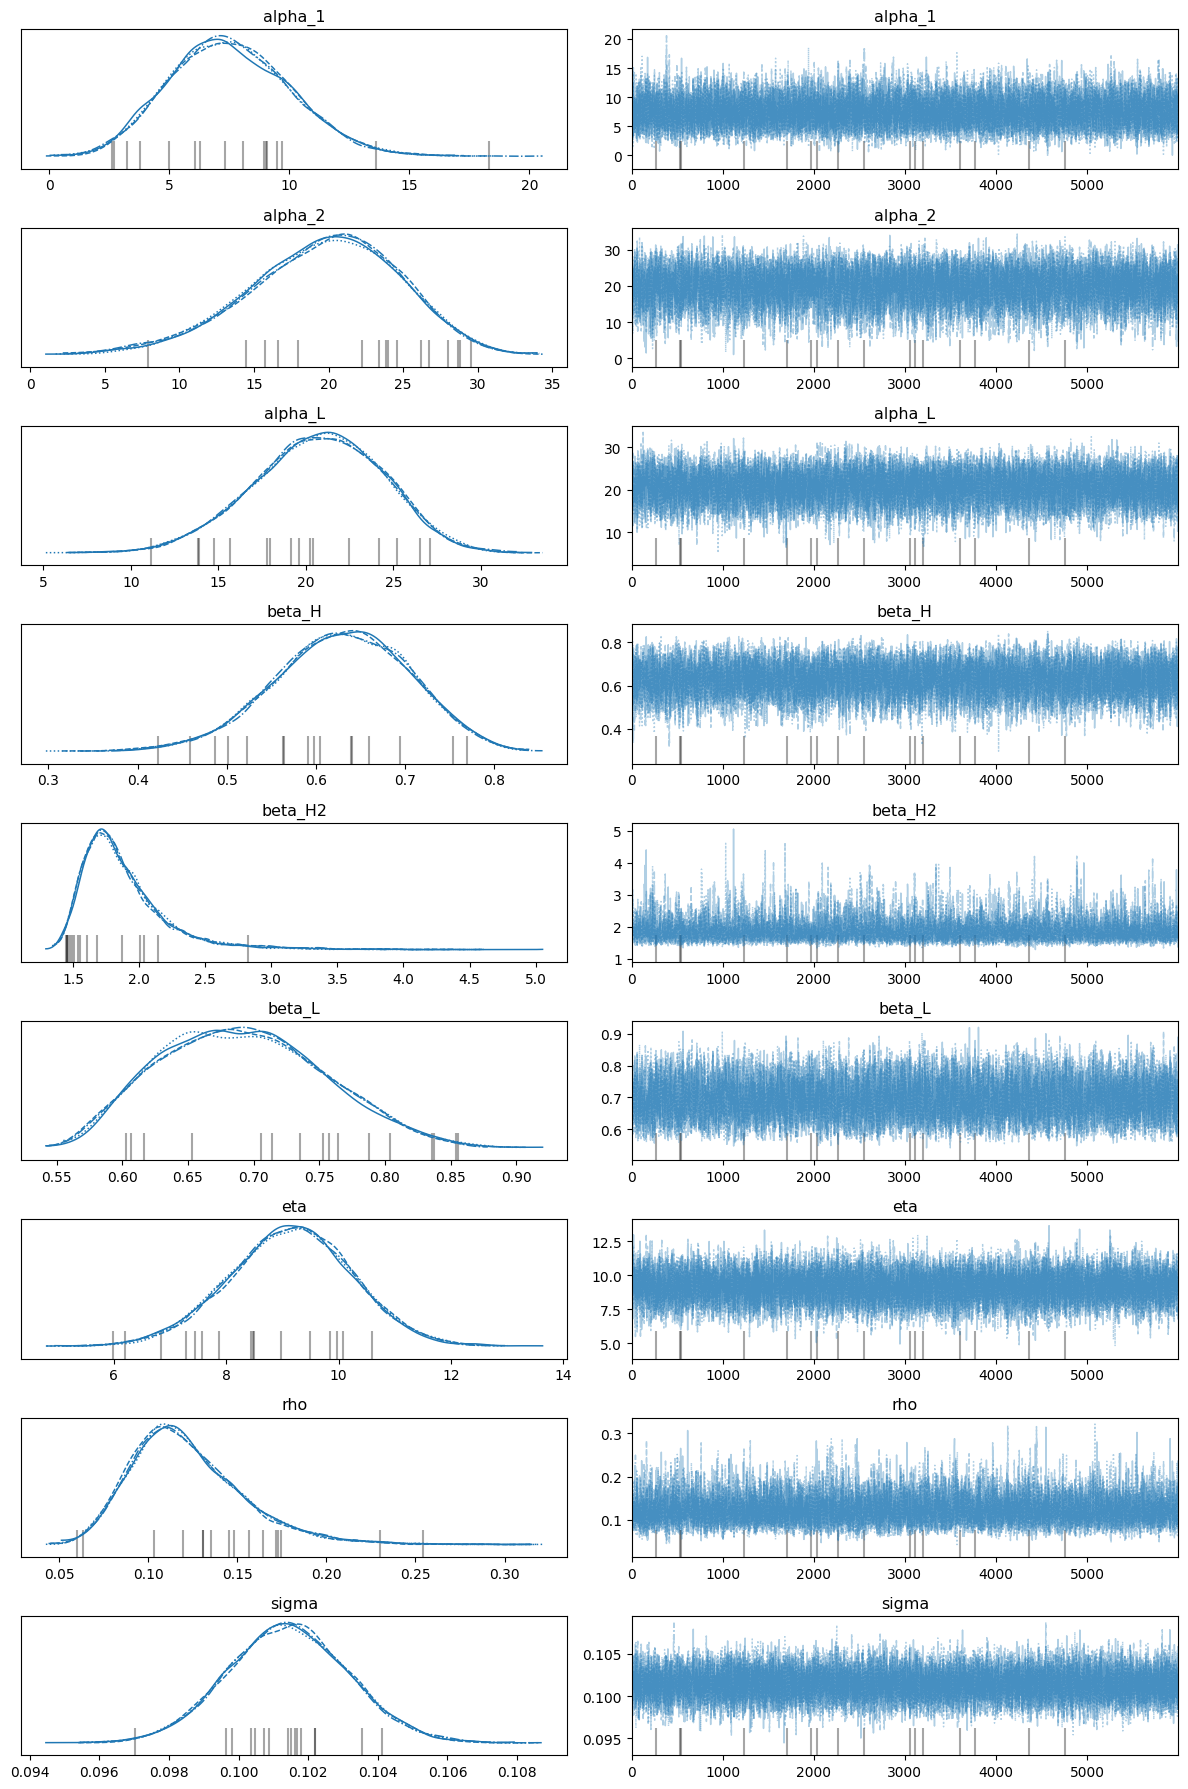

In [9]:
az.plot_trace(idata)
plt.tight_layout()

In [10]:
posterior_eta = idata["posterior"]["eta"]
credible_interval_eta = np.percentile(posterior_eta, [16, 50, 84])
posterior_rho = idata["posterior"]["rho"]
credible_interval_rho = np.percentile(posterior_rho, [16, 50, 84])
posterior_beta_L = idata["posterior"]["beta_L"]
credible_interval_beta_L = np.percentile(posterior_beta_L, [16, 50, 84])
posterior_beta_H = idata["posterior"]["beta_H"]
credible_interval_beta_H = np.percentile(posterior_beta_H, [16, 50, 84])
print(credible_interval_eta)
print(credible_interval_rho)
print(credible_interval_beta_L)
print(credible_interval_beta_H)


[ 8.05638163  9.17174465 10.22695378]
[0.09216166 0.11726668 0.15161701]
[0.62692711 0.68919503 0.75669791]
[0.55377925 0.63133811 0.70500046]


In [11]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_1,7.550,2.499,2.920,12.139,0.023,0.017,12071.447,13526.552,1.0
alpha_2,19.690,5.011,10.207,28.929,0.064,0.046,6211.122,7338.907,1.0
alpha_L,20.703,3.701,13.542,27.312,0.041,0.029,8090.135,13051.407,1.0
beta_H,0.629,0.075,0.491,0.770,0.001,0.001,7773.571,10416.917,1.0
beta_H2,1.876,0.331,1.411,2.462,0.005,0.003,5562.553,6514.925,1.0
beta_L,0.692,0.062,0.579,0.801,0.001,0.001,5756.116,8234.287,1.0
eta,9.149,1.094,7.076,11.197,0.010,0.007,11984.345,12926.309,1.0
rho,0.122,0.032,0.067,0.181,0.000,0.000,9435.697,11318.632,1.0
sigma,0.101,0.002,0.098,0.105,0.000,0.000,15636.086,13876.839,1.0


In [12]:
posterior_eta.values.flatten()

array([8.67155313, 8.72957465, 8.97057556, ..., 8.78269054, 8.30747011,
       7.76190439])

In [13]:
# Alternative method to find mode using histogram
def get_histogram_mode(data, bins=500):
    hist, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mode = bin_centers[np.argmax(hist)]
    return mode

# Extracting modes using histogram method for comparison
hist_modes = {}
for var in idata.posterior.data_vars:
    samples = idata.posterior[var].values.flatten()
    mode = get_histogram_mode(samples)
    hist_modes[var] = mode

print("Histogram modes of each posterior:")
for var, mode in hist_modes.items():
    print(f"{var}: {mode}")

Histogram modes of each posterior:
alpha_1: 7.120158544320787
alpha_2: 21.931350179880546
alpha_L: 21.18353869563891
beta_H: 0.6252102064969942
beta_H2: 1.6773147919044604
beta_L: 0.6851447003445303
eta: 9.343024231095466
rho: 0.10798998199480775
sigma: 0.10138331519363658


In [14]:
from scipy.stats import gaussian_kde

# Assuming `idata` is your InferenceData object with posterior samples
posterior_samples = idata.posterior

# Function to compute the mode using KDE
def get_mode_kde(data):
    kde = gaussian_kde(data)
    x_grid = np.linspace(min(data), max(data), 1000)
    mode = x_grid[np.argmax(kde(x_grid))]
    return mode

# Extracting modes for each parameter using KDE
kde_modes = {}
for var in idata.posterior.data_vars:
    samples = idata.posterior[var].values.flatten()
    mode = get_mode_kde(samples)
    kde_modes[var] = mode

print("KDE modes of each posterior:")
for var, mode in kde_modes.items():
    print(f"{var}: {mode}")


KDE modes of each posterior:
alpha_1: 7.189643487444427
alpha_2: 20.783567873701728
alpha_L: 21.171149721824516
beta_H: 0.6395018760801943
beta_H2: 1.7116430471778599
beta_L: 0.6799779044277813
eta: 9.312131539350574
rho: 0.10945345132056047
sigma: 0.10143318748439259


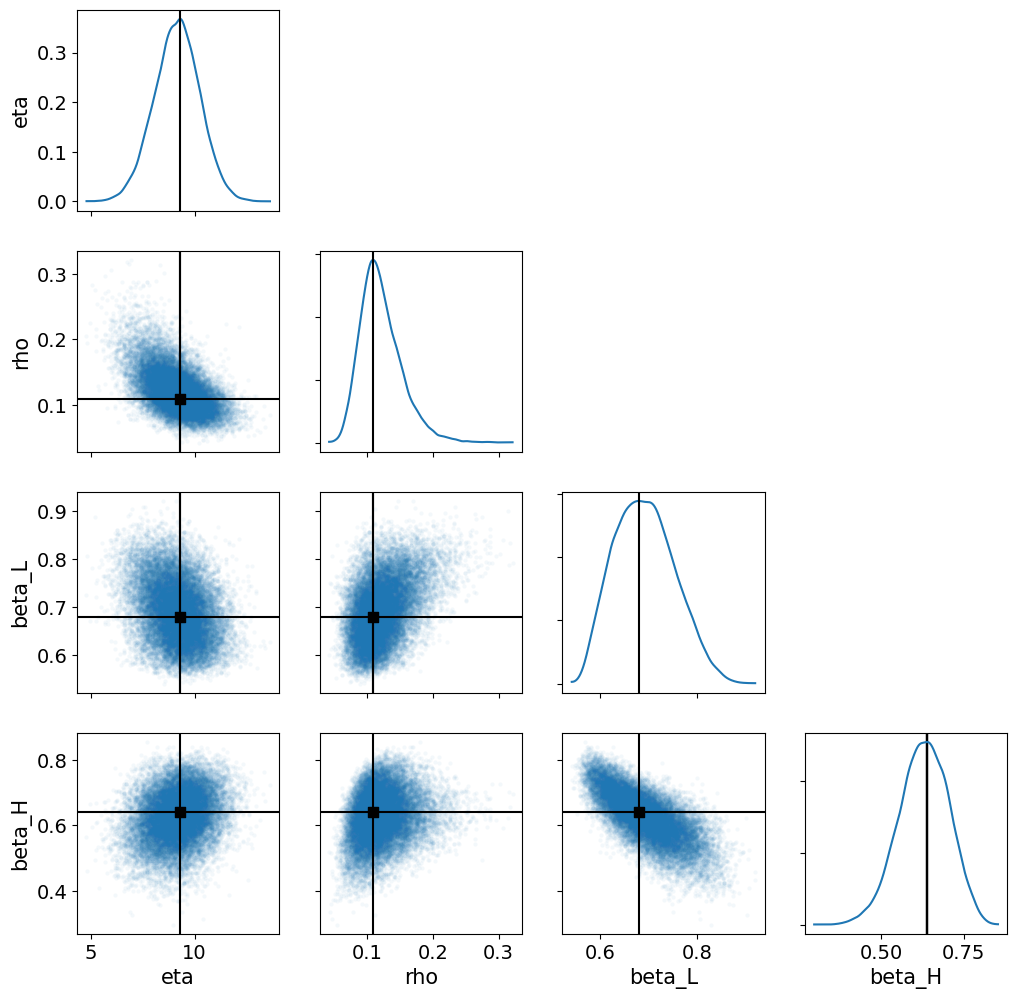

In [15]:
az.plot_pair(
    idata,
    marginals=True,
    point_estimate="mode",
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.05},
    var_names=["eta", "rho", "beta_L", "beta_H"],
);

In [19]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
import arviz as az  # Assume idata is an ArviZ InferenceData object

# Assume `idata` is your InferenceData object with posterior samples
posterior_samples = idata.posterior

# Define a function to evaluate the joint density using KDE
def joint_kde_density(point, samples):
    kde = gaussian_kde(samples.T)  # Transpose for proper shape
    return -kde(point)  # Negative because we are minimizing

# Extract the samples of all four parameters of interest
param_names = ['rho', 'eta', 'beta_L', 'beta_H', 'beta_H2', 'alpha_L', 'alpha_1', 'alpha_2']  # Replace with actual parameter names
sample_arrays = [posterior_samples[param].values.flatten() for param in param_names]

# Combine samples into a 2D array for joint distribution
joint_samples = np.vstack(sample_arrays).T

# Initial guess for the optimizer (mean of samples can be a good starting point)
initial_guess = np.mean(joint_samples, axis=0)

# Perform the optimization to find the mode
result = minimize(joint_kde_density, initial_guess, args=(joint_samples,), method='L-BFGS-B')

# The result contains the mode of the joint distribution
global_mode = result.x

# Print the global mode of the joint distribution
print(f"Global mode of the joint distribution ({', '.join(param_names)}): {global_mode}")

Global mode of the joint distribution (rho, eta, beta_L, beta_H, beta_H2, alpha_L, alpha_1, alpha_2): [ 0.11827327  9.27380111  0.68162608  0.64199059  1.84907079 20.98691424
  6.85521939 19.02656283]


In [20]:
# define the error function 2 param modes
def error_function(n_LF, n_HF):
    eta = 11.20294568777112
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = 34422.595850790254
    beta_L = 1.1406839520015446
    beta_H = 4.145389781446169
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    beta_H2 = 2.713544143928366
    # alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    alpha_L = 7.8176404049598816
    alpha_1 = 18.553167013696203
    alpha_2 = 7.5153891398955235

    sigma_lg_Phi = 0.21450697746101002   # standard deviation of the log of the error function
    # return 10**(np.log10(eta) + np.log10((rho / (n_LF**(beta_L) * n_HF**(beta_H)) + (1 - rho) / (alpha + n_HF**(beta_H2)))))
    lg_Phi = np.log10(eta) + np.log10(rho / ( (n_LF + n_HF) * (n_LF + alpha_L)**(beta_L-1) * (n_HF + alpha_1)**(beta_H-1) ) + 1 / (alpha_2 + n_HF)**(beta_H2))
    
    mode_Phi = 10**lg_Phi * np.exp(-sigma_lg_Phi**2 * (np.log(10))**2)
    mean_Phi = 10**lg_Phi * np.exp(1/2 * (sigma_lg_Phi * np.log(10))**2)
    median_Phi = 10**lg_Phi
    return median_Phi

In [21]:
# loss  mean
lg_phi = np.log10(error_function(n_LF, n_HF))
loss = np.mean((lg_phi - np.log(rel_error))**2)

In [22]:
loss

0.4265699575906271